# Unsupervised Learning

Add image

# Introduction and Dataset

## Background

add contents

- K-Means and PCA are covered in course notes
- Could perform k-means landcover classification of RMF forests
- Unsupervised learning can be useful for landcover classification because we may not know how many classes to use
- Do we want multiple forest cover classes?
- We want classes that are spectrally unique
- If we don't have sufficient prior knowledge about a dataset, unsupervised learning can help us better understand the structure of the data
- Unsupervised classification is effective in situations where we might not have training data

TODO: add citations:

- https://doi.org/10.1093/forestry/cpw011
- And one for Sentinel-2 landcover classification



## Tutorial goals

**Goal 1: Apply K-means clustering to perform landcover classification using Sentinel-2 imagery over the PRF.**

**Goal 2: Investigate the composition of the clusters**


-----

## Data

This tutorial makes use of ...

In [75]:
import rioxarray as rio
import numpy as np
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [44]:
# Load data

s2_2018_fpath = 'data/petawawa_s2_2018.tif'

boundary_fpath = 'data/boundary.gpkg'

s2_2018 = rio.open_rasterio(s2_2018_fpath)

boundary_gdf = gpd.read_file(boundary_fpath).to_crs(s2_2018.rio.crs)

# Check the shape of the raster values
s2_2018.values.shape

(12, 937, 1824)

# Visualize the PRF Sentinel-2 imagery again

In [45]:
# Define function to get simplified matplotlib output

def simplify_plt(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

<Axes: >

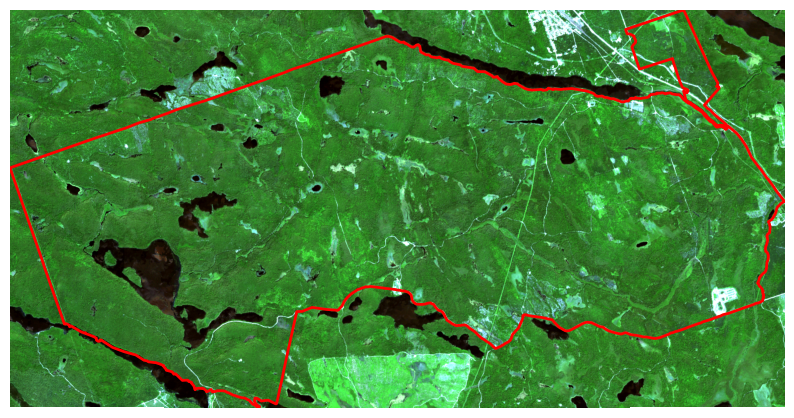

In [46]:
# Perform a percentage clip to remove very bright/dark pixels and enhance image contrast

def plot_rgb(rgb, ax, low_perc=1, high_perc=99):

    #find the values to do contrast stretching
    vmin, vmax = np.nanpercentile(rgb, (low_perc, high_perc))

    #ensure values are between 0 and 1
    rgb = np.clip(rgb, vmin, vmax)

    # Visualize the PRF Sentinel-2 imagery
    show(rgb, ax=ax, transform=s2_2018.rio.transform(), adjust=True)


fig, ax = plt.subplots(figsize=(10, 10))

plot_rgb(s2_2018.values[1:4], ax=ax)

simplify_plt(ax)

boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

In [47]:
# Check how many pixels are in the image
n_pixels = s2_2018.shape[1] * s2_2018.shape[2]

print(f'There are {n_pixels} in the image.')

There are 1709088 in the image.


2491


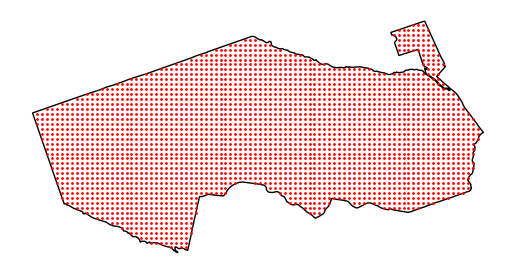

In [48]:
# We want to classify all the pixels in the image, to do so we will start with a sample  of points

# We will sample points on a grid with points spaced 300 meters apart

spacing = 200

xmin, ymin, xmax, ymax = boundary_gdf.total_bounds

xcoords = [i for i in np.arange(xmin, xmax, spacing)]
ycoords = [i for i in np.arange(ymin, ymax, spacing)]

pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1, 2) #A 2D array like [[x1,y1], [x1,y2], ...
sample_pts = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
sample_pts = gpd.GeoSeries(sample_pts, crs=boundary_gdf.crs)

sample_pts.name = 'geometry'

sample_pts = gpd.sjoin(gpd.GeoDataFrame(sample_pts), boundary_gdf[['geometry']], how="inner", predicate='within')

ax = boundary_gdf.plot(color='none', edgecolor='black')

sample_pts.plot(ax=ax, color='red', markersize=1)

simplify_plt(ax)

print(len(sample_pts))

In [76]:
# Extract pixel values for each band at the sample points

plot_coords = [(geom.x, geom.y) for geom in sample_pts.geometry]

sample_pixels_ls = [s2_2018.sel(x=c[0], y=c[1], method="nearest").values for c in plot_coords]

sample_pixels_arr = np.stack(sample_pixels_ls, axis=0)


samples_df = pd.DataFrame(sample_pixels_arr,
             columns=['Aerosols', 'Blue', 'Green', 'Red', 
                      'Red Edge 1', 'Red Edge 2', 'Red Edge 3', 
                      'NIR', 'Red Edge 4', 'Water vapor', 
                      'SWIR 1', 'SWIR 2'])
samples_df


,Aerosols,Blue,Green,Red,Red Edge 1,Red Edge 2,Red Edge 3,NIR,Red Edge 4,Water vapor,SWIR 1,SWIR 2
0,0.01505,0.02300,0.04800,0.01855,0.08155,0.32965,0.41315,0.40715,0.43460,0.37585,0.17235,0.07385
1,0.01250,0.01710,0.02980,0.01330,0.05425,0.20595,0.27335,0.27255,0.28695,0.35720,0.12945,0.05805
2,0.01405,0.01930,0.03420,0.01810,0.05875,0.20195,0.25340,0.26020,0.27805,0.32235,0.13330,0.06000
3,0.01400,0.02510,0.05825,0.02455,0.08955,0.33650,0.42485,0.47235,0.46075,0.41050,0.18310,0.08050
4,0.01325,0.01560,0.03225,0.01240,0.06875,0.25960,0.33925,0.31620,0.35280,0.37420,0.14335,0.06010
...,...,...,...,...,...,...,...,...,...,...,...,...
2486,0.01930,0.03255,0.05760,0.03365,0.08995,0.28525,0.35275,0.35565,0.38745,0.38660,0.16980,0.08015
2487,0.03490,0.06830,0.08780,0.08810,0.11805,0.26695,0.31635,0.27570,0.33510,0.34555,0.19275,0.13115
2488,0.01850,0.02310,0.04310,0.02115,0.06450,0.21775,0.28495,0.35025,0.30685,0.28200,0.12750,0.05980
2489,0.01885,0.02075,0.03705,0.01940,0.06795,0.23755,0.28725,0.33725,0.31320,0.34585,0.13735,0.06360


In [77]:
# Perform k-means clustering on the sample points

kmeans = KMeans(n_clusters=4, # Set the number of clusters
                random_state=0).fit(samples_df) # Set the random seed for reproducibility

samples_df['kmeans_label'] = kmeans.labels_

clust_centers = kmeans.cluster_centers_

kmeans

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


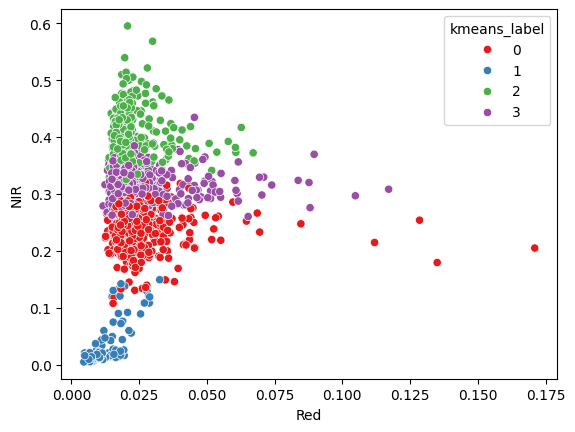

In [78]:
# Plot Red and NIR bands against each other with cluster centers shown

ax = sns.scatterplot(data=samples_df, 
                x='Red', 
                y='NIR', 
                hue='kmeans_label', 
                palette='Set1')


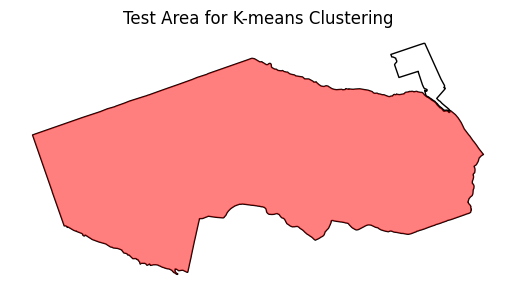

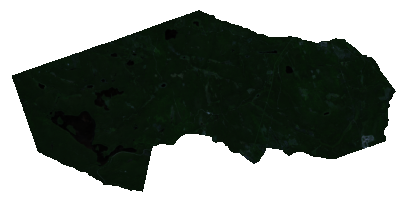

In [79]:
# Get a subset area of PRF to test the kmeans clustering

# Get a subset window

# test_area = boundary_gdf.centroid[1].buffer(1500, cap_style='square')

# test_area = gpd.GeoDataFrame(index=[0], geometry=[test_area], crs=boundary_gdf.crs)

test_area = boundary_gdf.copy()
test_area = test_area.iloc[1:]

# View subset window 

ax = boundary_gdf.plot(color='none', edgecolor='black')
test_area.plot(ax=ax, color='red', alpha=0.5)
ax.set_title('Test Area for K-means Clustering')

simplify_plt(ax)

plt.show()

# Clip sentinel-2 imagery to test area and view
s2_2018_subset = s2_2018.rio.clip(test_area.geometry, test_area.crs)

fig, ax = plt.subplots(figsize=(5, 5))

show(s2_2018_subset.values[1:4], 
     transform=s2_2018_subset.rio.transform(), 
     adjust=True,
     ax=ax)

simplify_plt(ax)

plt.show()

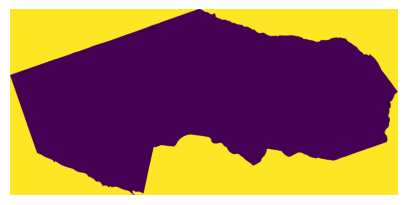

In [80]:
# Check for NAs in the raster
nan_count_mask = np.isnan(s2_2018_subset.values).sum(axis=0)

fig, ax = plt.subplots(figsize=(5, 5))
show(nan_count_mask, ax=ax)
simplify_plt(ax)

# Replace NAs with zeroes
s2_2018_subset = s2_2018_subset.fillna(0)

In [88]:

n_bands = s2_2018_subset.shape[0]

pixels = s2_2018_subset.values.reshape(n_bands, -1).T

s2_2018_subset_df = (pd.DataFrame(pixels, 
                                 columns=samples_df.columns.tolist()[:-1])
                                 )



s2_2018_subset_df

,Aerosols,Blue,Green,Red,Red Edge 1,Red Edge 2,Red Edge 3,NIR,Red Edge 4,Water vapor,SWIR 1,SWIR 2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1591474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1591475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1591476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1591477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# Apply k-means clustering to the test area

pred = kmeans.predict(s2_2018_subset_df)

pred = pred.reshape(s2_2018_subset.shape[1:3])

pred.shape

(873, 1823)

In [90]:
# Clip raster to study area

assert s2_2018_subset.values.shape[1:3] == pred.shape, "Shape mismatch between raster and prediction array."

# Assing kmeans labels to the first s2 raster band, then drop all other bands
# This will create a new raster where each pixel is assigned a cluster label

kmeans_ras = s2_2018_subset.copy(deep=True)

kmeans_ras.values[0, :, :] = pred

kmeans_ras = kmeans_ras.sel(band=1)

kmeans_ras.attrs["long_name"] = "kmeans_label"

# Finally, clip kmeans ras to the target area
kmeans_ras = kmeans_ras.rio.clip(test_area.geometry, test_area.crs)

kmeans_ras

<xarray.DataArray (y: 873, x: 1823)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(873, 1823), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 15kB 2.973e+05 2.973e+05 ... 3.155e+05 3.155e+05
  * y            (y) float64 7kB 5.098e+06 5.098e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      kmeans_label

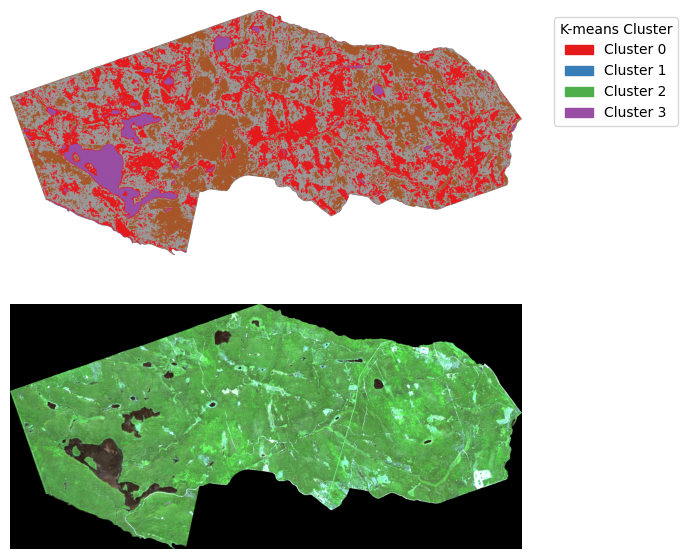

In [97]:

import matplotlib.patches as mpatches
from matplotlib import colormaps

# Plot pred area and RGB image side by side

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))

# Plot the kmeans raster
show(kmeans_ras.values, ax=ax1, transform=kmeans_ras.rio.transform(), cmap='Set1')

# Add a legend for the clusters
n_clusters = int(np.nanmax(kmeans_ras.values) + 1)  # assuming labels start at 0
cmap = colormaps.get_cmap('Set1')

handles = [
    mpatches.Patch(color=cmap(i), label=f'Cluster {i}')
    for i in range(n_clusters)
]

ax1.legend(handles=handles, title="K-means Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plot_rgb(s2_2018_subset.values[1:4], ax=ax2)

simplify_plt(ax1)

simplify_plt(ax2)

In [98]:
# Let's examine the clusters more closely using ancillary LiDAR data

als_metrics = rio.open_rasterio(r'data/als_metrics.tif')
als_metrics

<xarray.DataArray (band: 67, y: 366, x: 746)> Size: 73MB
[18293412 values with dtype=float32]
Coordinates:
  * band         (band) int64 536B 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60...